#Dependências

In [1]:
#!pip -q install torch torchvision torchaudio
#!pip -q install torch_geometric
#!pip -q install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cpu.html

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

# Tratar dados
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix


import re
from imblearn.under_sampling import RandomUnderSampler

# Importando CSV
#from google.colab import drive

# PyG
import torch
from torch_geometric.data import Data
from torch_geometric.utils import remove_isolated_nodes
from torch_geometric.utils import contains_isolated_nodes
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch import nn

### Lendo CSV do Google Drive

In [3]:
filename = "./data/covid_mexico.csv"
covid_df = pd.read_csv(filename, sep=",")

In [4]:
covid_df.shape

(1048575, 21)

In [5]:
covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [6]:
covid_df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# Pré Tratamento

### Tratando DATE_DIED

In [8]:
#A Data "9999-99-99" significa que o paciente sobreviveu
covid_df['DATE_DIED'].value_counts()

DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: count, Length: 401, dtype: int64

In [9]:
#Cria nova coluna binaria e preenche com os valores baseando na coluna DATE_DIED
covid_df['PASSED'] = [0 if l == '9999-99-99' else 1 for l in covid_df.DATE_DIED]

#Remove coluna denecessária
covid_df.drop(columns=["DATE_DIED"], inplace=True)

covid_df.PASSED.value_counts()

PASSED
0    971633
1     76942
Name: count, dtype: int64

# Explorando Dados

### Descrevendo dataframe

In [10]:
for i in covid_df.columns:
    print(i,"----->", len(covid_df[i].unique()))

USMER -----> 2
MEDICAL_UNIT -----> 13
SEX -----> 2
PATIENT_TYPE -----> 2
INTUBED -----> 4
PNEUMONIA -----> 3
AGE -----> 121
PREGNANT -----> 4
DIABETES -----> 3
COPD -----> 3
ASTHMA -----> 3
INMSUPR -----> 3
HIPERTENSION -----> 3
OTHER_DISEASE -----> 3
CARDIOVASCULAR -----> 3
OBESITY -----> 3
RENAL_CHRONIC -----> 3
TOBACCO -----> 3
CLASIFFICATION_FINAL -----> 7
ICU -----> 4
PASSED -----> 2


### Percentual de mortes

In [11]:
def plot_percentual_deads(df):
    percentual_deads = round(df.PASSED.mean() * 100, 2)
    print(f"Percentural of deads {percentual_deads}]\n")

    ax = df.PASSED.value_counts(dropna=False).plot(kind="bar", title=f"Pacientes x Óbitos -> ({percentual_deads}%)", color=["blue", "red"], ylabel="Qtd. Pacientes")

    container = ax.containers[0]
    ax.bar_label(container)
    ax.set_xticklabels(["Recuperados", "Óbitos"], rotation=0)


Percentural of deads 7.34]



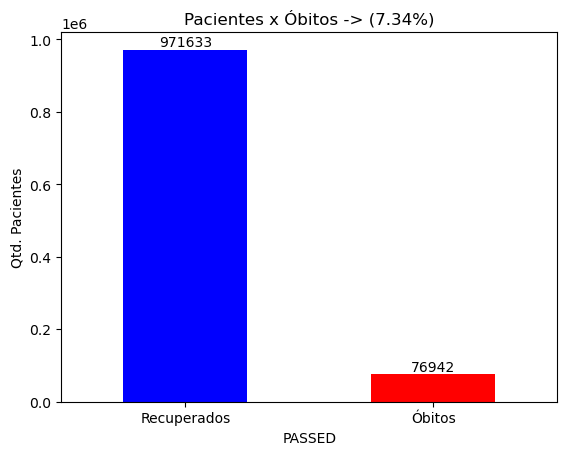

In [12]:
plot_percentual_deads(covid_df)

In [13]:
covid_df.shape

(1048575, 21)

# Tratando Dados

### Coluna PREGNANT

In [14]:
covid_df['PREGNANT'].value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [15]:
#Altera os valores para Homens, para sem gravidez
covid_df['PREGNANT'] = covid_df['PREGNANT'].replace(97, 2)

#Remove linhas com valores ausentes
covid_df = covid_df.drop(covid_df[covid_df.PREGNANT == 98].index)
covid_df = covid_df[(covid_df.PREGNANT == 1) | (covid_df.PREGNANT == 2)]

In [16]:
#Resultado apos tratamento
# Como há poucas linhas com mulheres grávidas,
# essa coluna se torna uma constante, com isso, não necessita deste atributo
# e será removido mais a frente.
covid_df.PREGNANT.value_counts(dropna=False)

PREGNANT
2    1036690
1       8131
Name: count, dtype: int64

### Coluna INTUBED
Para casos em que INTUBED é nulo e o paciente hospitalizado, receberá o valor NaN. De outra forma, recebe 2 [Não], quando o paciente foi para casa.

In [17]:
# Paciente [2] hospitalizado
filter_intubed_1 = (covid_df["INTUBED"] >= 97) & (covid_df["PATIENT_TYPE"] == 2)
covid_df.loc[filter_intubed_1, "INTUBED"] = np.nan
covid_df["INTUBED"].value_counts()

INTUBED
97.0    845277
2.0     158768
1.0      33609
Name: count, dtype: int64

In [18]:
# Paciente [1] para casa
filter_intubed_2 = (covid_df["INTUBED"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)
covid_df.loc[filter_intubed_2, "INTUBED"] = 2
covid_df["INTUBED"].value_counts()

INTUBED
2.0    1004045
1.0      33609
Name: count, dtype: int64

### Coluna ICU
Se ICU nulo e foi hospitalizado, então recebe NaN. Se não, recebe 2 [Não].

In [19]:
# Paciente [2] hospitalizado
filter_icu_1 = (covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 2)
covid_df.loc[filter_icu_1, "ICU"] = np.nan
covid_df["ICU"].value_counts()

ICU
97.0    845277
2.0     175386
1.0      16830
Name: count, dtype: int64

In [20]:
# Paciente [1] para casa
filter_icu_2 = (covid_df["ICU"] >= 97) & (covid_df["PATIENT_TYPE"] == 1)
covid_df.loc[filter_icu_2, "ICU"] = 2
covid_df["ICU"].value_counts()

ICU
2.0    1020663
1.0      16830
Name: count, dtype: int64

In [21]:
covid_df.isna().sum()

USMER                      0
MEDICAL_UNIT               0
SEX                        0
PATIENT_TYPE               0
INTUBED                 7167
PNEUMONIA                  0
AGE                        0
PREGNANT                   0
DIABETES                   0
COPD                       0
ASTHMA                     0
INMSUPR                    0
HIPERTENSION               0
OTHER_DISEASE              0
CARDIOVASCULAR             0
OBESITY                    0
RENAL_CHRONIC              0
TOBACCO                    0
CLASIFFICATION_FINAL       0
ICU                     7328
PASSED                     0
dtype: int64

### Colunas NaN

In [22]:
def verify_num_cols(df):
    # Média ordenada e colunas com valor vazio
    mean_na = df.isna().mean().sort_values(ascending=False)

    # Cria DF de colunas nulas
    df_na = pd.DataFrame({"percentual": mean_na})

    return df_na

def remove_nan_cols_above_limit(df, cols_to_ignore, limit=0.30):
    # Obtém colunas nulas e seu percentual
    df_na = verify_num_cols(df)

    # Ignora colunas
    df_na.drop(cols_to_ignore, inplace=True)

    # Filtra colunas pelo limite
    df_na_above_limit = df_na[df_na.percentual >= limit]

    # Obtém as colunas a serem dropadas
    columns_to_drop = df_na_above_limit.index

    # Dropa colunas
    df.drop(columns=columns_to_drop, inplace=True)

    return df, df_na_above_limit

In [23]:
# Remove colunas nulas acima do limite de 5%
# Coluna considera importante para ser removida
cols_to_ignore = ["ICU", "INTUBED"]
_, df_na = remove_nan_cols_above_limit(covid_df, cols_to_ignore, limit=0.05)

# Colunas removidas
df_na

,percentual


In [24]:
covid_df.shape

(1044821, 21)

In [25]:
covid_df.isna().sum()

USMER                      0
MEDICAL_UNIT               0
SEX                        0
PATIENT_TYPE               0
INTUBED                 7167
PNEUMONIA                  0
AGE                        0
PREGNANT                   0
DIABETES                   0
COPD                       0
ASTHMA                     0
INMSUPR                    0
HIPERTENSION               0
OTHER_DISEASE              0
CARDIOVASCULAR             0
OBESITY                    0
RENAL_CHRONIC              0
TOBACCO                    0
CLASIFFICATION_FINAL       0
ICU                     7328
PASSED                     0
dtype: int64

### Removendo colunas desnecessárias

* PREGNANT - Coluna constante

In [26]:
# Removendo colunas
covid_df.drop(columns=["PREGNANT"], inplace=True)

In [27]:
# Remove linhas com alguma coluna nula
covid_df.dropna(inplace=True)

In [28]:
# Nessa base valores como 97, 98 e 99 são nulos
def check_columns():
  for i in covid_df.columns:
    temp_df = covid_df[(covid_df[i] == 99) | (covid_df[i] == 97) | (covid_df[i] == 98)]
    print(i + " : ",temp_df[i].count())

check_columns()

USMER :  0
MEDICAL_UNIT :  0
SEX :  0
PATIENT_TYPE :  0
INTUBED :  0
PNEUMONIA :  10652
AGE :  327
DIABETES :  3133
COPD :  2797
ASTHMA :  2770
INMSUPR :  3159
HIPERTENSION :  2906
OTHER_DISEASE :  4759
CARDIOVASCULAR :  2865
OBESITY :  2838
RENAL_CHRONIC :  2804
TOBACCO :  3018
CLASIFFICATION_FINAL :  0
ICU :  0
PASSED :  0


In [29]:
columns_filter = ['PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
for c in columns_filter:
    covid_df = covid_df[(covid_df[c] == 1) | (covid_df[c] == 2)]

check_columns()

USMER :  0
MEDICAL_UNIT :  0
SEX :  0
PATIENT_TYPE :  0
INTUBED :  0
PNEUMONIA :  0
AGE :  321
DIABETES :  0
COPD :  0
ASTHMA :  0
INMSUPR :  0
HIPERTENSION :  0
OTHER_DISEASE :  0
CARDIOVASCULAR :  0
OBESITY :  0
RENAL_CHRONIC :  0
TOBACCO :  0
CLASIFFICATION_FINAL :  0
ICU :  0
PASSED :  0


# Encoding

## Label Encoding

In [30]:
label_encoder = LabelEncoder()

In [31]:
covid_df["CLASIFFICATION_FINAL"] = label_encoder.fit_transform(covid_df["CLASIFFICATION_FINAL"])
covid_df["USMER"] = label_encoder.fit_transform(covid_df["USMER"])

## One-hot Encoding

In [32]:
# Define colunas a serem ignoradas
ignore_columns = ["CLASIFFICATION_FINAL", "AGE", "PASSED", "USMER", ]
onehot_encoder_cols = [col for col in covid_df.columns.tolist() if col not in ignore_columns]

# Instancia o OneHotEnconder
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [33]:
# Realiza o fit-transform
one_hot_result = one_hot_encoder.fit_transform(covid_df[onehot_encoder_cols])

# Obtem os nomes das colunas
one_hot_col_result = one_hot_encoder.get_feature_names_out(onehot_encoder_cols)

# Armazena em um novo DF
one_hot_col_df = pd.DataFrame(one_hot_result, columns=one_hot_col_result, index=covid_df.index)
one_hot_col_df.shape

(1019666, 43)

In [34]:
one_hot_col_result

array(['MEDICAL_UNIT_1', 'MEDICAL_UNIT_2', 'MEDICAL_UNIT_3',
       'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9',
       'MEDICAL_UNIT_10', 'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12',
       'MEDICAL_UNIT_13', 'SEX_1', 'SEX_2', 'PATIENT_TYPE_1',
       'PATIENT_TYPE_2', 'INTUBED_1.0', 'INTUBED_2.0', 'PNEUMONIA_1',
       'PNEUMONIA_2', 'DIABETES_1', 'DIABETES_2', 'COPD_1', 'COPD_2',
       'ASTHMA_1', 'ASTHMA_2', 'INMSUPR_1', 'INMSUPR_2', 'HIPERTENSION_1',
       'HIPERTENSION_2', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2',
       'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'OBESITY_1', 'OBESITY_2',
       'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'TOBACCO_1', 'TOBACCO_2',
       'ICU_1.0', 'ICU_2.0'], dtype=object)

In [35]:
# Dropa colunas antigas e adiciona as novas
covid_df = covid_df.drop(columns=onehot_encoder_cols).join(one_hot_col_df)
covid_df.shape

(1019666, 47)

In [36]:
# Liberar memoria
del one_hot_col_df
del one_hot_result

# Estratificando Dados

* Nesse caso, é necessário reduzir de forma estratificada os dados, já que essa base
possui aproximadamente 73 mil óbitos (classe minoritária). Ou seja,
aplicar o RUS faria com que a base tivesse cerca de 73 mil óbitos e 73 mil sobreviventes
o que gera mais de 140 mil dados para serem passados pela etapa de ajuste de hiperparâmetros,
fazendo com que seja lento a busca pelos hiperparâmetros.
* Com isso, reduzimos os dados em 15%. Aplicando o RUS cada classe é representada por
aproximadamente 11 mil dados (total de 22 mil).
* Cada paciente é um nó, logo a quantidade de aresta possíveis é n(n - 1)

In [37]:
# Agrupa por PASSED e aplica o SAMPLE em cada grupo
covid_df = covid_df.groupby("PASSED", group_keys=False).apply(lambda g: g.sample(frac=0.15))

# Balanceando Dados

In [38]:
rus = RandomUnderSampler(sampling_strategy='majority')
X,y = rus.fit_resample(covid_df.drop(columns=["PASSED"]), covid_df.PASSED)

In [39]:
y.value_counts()

PASSED
0    10996
1    10996
Name: count, dtype: int64

# Transformando Dataset em estrutura para grafo

## Determinado propriedades
* Nodes -> Pessoas (cada linha da tabela)
* Edges -> Similaridade das doenças de cada pessoa
* Nodes features -> Comorbidades, etc.
* Labels -> Se a pessoa pode morrer por covid

## Extraindo Node Features

In [40]:
X.columns

Index(['USMER', 'AGE', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT_1',
       'MEDICAL_UNIT_2', 'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5',
       'MEDICAL_UNIT_6', 'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9',
       'MEDICAL_UNIT_10', 'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12',
       'MEDICAL_UNIT_13', 'SEX_1', 'SEX_2', 'PATIENT_TYPE_1', 'PATIENT_TYPE_2',
       'INTUBED_1.0', 'INTUBED_2.0', 'PNEUMONIA_1', 'PNEUMONIA_2',
       'DIABETES_1', 'DIABETES_2', 'COPD_1', 'COPD_2', 'ASTHMA_1', 'ASTHMA_2',
       'INMSUPR_1', 'INMSUPR_2', 'HIPERTENSION_1', 'HIPERTENSION_2',
       'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'CARDIOVASCULAR_1',
       'CARDIOVASCULAR_2', 'OBESITY_1', 'OBESITY_2', 'RENAL_CHRONIC_1',
       'RENAL_CHRONIC_2', 'TOBACCO_1', 'TOBACCO_2', 'ICU_1.0', 'ICU_2.0'],
      dtype='object')

In [41]:
# Reseta o index
covid_df = covid_df.reset_index(drop=True)
X = X.reset_index(drop=True)

In [42]:
personal_info = ['SEX_1', 'SEX_2', 'AGE']

clinicians = ['USMER', 'PATIENT_TYPE_1', 'PATIENT_TYPE_2', 'CLASIFFICATION_FINAL', 
              'ICU_1.0', 'ICU_2.0', 'INTUBED_1.0', 'INTUBED_2.0', 'MEDICAL_UNIT_1',
       'MEDICAL_UNIT_2', 'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5',
       'MEDICAL_UNIT_6', 'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9',
       'MEDICAL_UNIT_10', 'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12',
       'MEDICAL_UNIT_13']

comorbities = ['PNEUMONIA_1', 'PNEUMONIA_2', 'DIABETES_1', 'DIABETES_2', 'COPD_1', 'COPD_2', 'ASTHMA_1', 'ASTHMA_2',
       'INMSUPR_1', 'INMSUPR_2', 'HIPERTENSION_1', 'HIPERTENSION_2',
       'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'CARDIOVASCULAR_1',
       'CARDIOVASCULAR_2', 'OBESITY_1', 'OBESITY_2', 'RENAL_CHRONIC_1',
       'RENAL_CHRONIC_2', 'TOBACCO_1', 'TOBACCO_2']

In [43]:
features = personal_info + comorbities + clinicians

all_features = X[features].to_numpy()
X.drop(columns=features, inplace=True)
all_features

array([[ 0.,  1., 26., ...,  0.,  1.,  0.],
       [ 0.,  1., 23., ...,  0.,  1.,  0.],
       [ 1.,  0., 35., ...,  0.,  1.,  0.],
       ...,
       [ 1.,  0., 58., ...,  0.,  0.,  0.],
       [ 0.,  1., 73., ...,  0.,  0.,  0.],
       [ 0.,  1., 72., ...,  0.,  0.,  0.]])

## Definindo similaridade

In [45]:
# Calcula a similaridade do cosseno para os pacientes
similarity = cosine_similarity(all_features)

In [46]:
# Defini um limiar para existir uma relação entre os pacientes
threshold = 0.999

# Cria a lista de adjacencia
adjacency_list = [[],[]]

# O resultado de similarity, é uma matriz de paciente x pacientes
# Onde cada elemento é o cosseno da similaridade
# Assim, percorremos paciente x parciente
for pac_i in range(len(similarity)):
    for pac_j in range(pac_i + 1, len(similarity[pac_i])):
        value = similarity[pac_i][pac_j]

        # True, Se o paciente não for si mesmo (i!=j) e
        #o cosseno da similiaridade for maior que o limiar

        if(pac_i != pac_j and value >= threshold):
            # Adiciona a->b e b->a
            adjacency_list[0].append(pac_i)
            adjacency_list[1].append(pac_j)

            adjacency_list[0].append(pac_j)
            adjacency_list[1].append(pac_i)

In [47]:
len(adjacency_list[0])

29205418

## Usando Pyg

In [48]:
# Define características e alvo
X_features = torch.from_numpy(all_features).float()
y_target = torch.from_numpy(y.to_numpy())

In [49]:
# Transforma valores para np.double
torch.from_numpy(all_features.astype(np.double))

tensor([[ 0.,  1., 26.,  ...,  0.,  1.,  0.],
        [ 0.,  1., 23.,  ...,  0.,  1.,  0.],
        [ 1.,  0., 35.,  ...,  0.,  1.,  0.],
        ...,
        [ 1.,  0., 58.,  ...,  0.,  0.,  0.],
        [ 0.,  1., 73.,  ...,  0.,  0.,  0.],
        [ 0.,  1., 72.,  ...,  0.,  0.,  0.]], dtype=torch.float64)

In [50]:
# Cria objeto tensor
edge_index = torch.tensor(adjacency_list, dtype=torch.long)

# Remove nós isolados
edge_index,_,_ = remove_isolated_nodes(edge_index)

data = Data(x=X_features, edge_index=edge_index, y=y_target)

In [51]:
# Liberar memória
del adjacency_list

In [52]:
def show_data_info(data):
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

show_data_info(data)

Number of nodes: 21992
Number of edges: 29205418
Average node degree: 1328.00
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [54]:
# Obtendo maior componente
transform = LargestConnectedComponents()
data = transform(data)

In [55]:
show_data_info(data)

Number of nodes: 20961
Number of edges: 29204768
Average node degree: 1393.29
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Split dados

In [56]:
def split_in_masks(data, test=0.3):
    # resetting data split
    split = T.RandomNodeSplit(num_test=test)
    return split(data)


## GAT

## Funções Auxiliares

In [57]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix
from datetime import datetime

def computes_metrics(target_labels, pred_labels):
    accuracy = accuracy_score(target_labels, pred_labels)
    f1 = f1_score(target_labels, pred_labels)
    roc_auc = roc_auc_score(target_labels, pred_labels)
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    
    return accuracy, precision, recall, f1, roc_auc

def get_df_results(size, csv_name):
    # Busca Df já escrito, caso não enconte, instancia um novo
    df_results = None
    try:
        df_results = pd.read_csv(csv_name, sep=",", index_col=0)
    except FileNotFoundError:
        df_results = pd.DataFrame(data=np.zeros(size))
    
    return df_results

def save_metrics(size, resultado, run):
    # Mudar o nome para cada grupo de rn_runs
    csv_name = "./results/gnn_mx_runs"

    # Obtem Df results    
    df_results = get_df_results(size, csv_name)

    # Escreve as métricas na coluna run respectiva
    df_results.iloc[:, run] = list(resultado)
    
    # Escreve df modificado
    df_results.to_csv(csv_name)
        
def print_metrics(pred_labels, target_labels, loss, metrics_results, epoch):
    print(f"Pred: {pred_labels.sum()}, Actual: {target_labels.sum()}")
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}')
    print(metrics_results)
    print("-----------------------------------------------")

## Execução

In [58]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch import nn

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GATConv(num_node_features, 20)
        self.conv2 = GATConv(20, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)

        return x

In [59]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward()

    optimizer.step()

    return loss

def predict(model, data, mask):
    out = model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    
    pred_labels = pred[mask]
    target_labels = data.y[mask]

    return pred_labels, target_labels

def train_epochs(model, data, optimizer, criterion, run, n_epochs=200, n_runs=10):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    splited_data = split_in_masks(data)

    for epoch in range(1, n_epochs + 1):
        loss = train(model, splited_data, optimizer, criterion)

        if epoch % 10 == 0:
            pred_labels, target_labels = predict(model, splited_data, splited_data.test_mask)

            metrics_results = computes_metrics(target_labels, pred_labels)
            print_metrics(pred_labels, target_labels, loss, metrics_results, epoch)
                
    # Salva as métricas ao fim do treinamento de cada run
    pred_labels, target_labels = predict(model, splited_data, splited_data.test_mask)
    save_metrics((len(metrics), n_runs), metrics_results, run)

In [60]:
# Definindo dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def monte_carlo_train(device, data, n_runs=10):
    # Extraindo quantidade de características e classes
    num_node_features = data.x.size(1)
    num_classes =  len(np.unique(data.y))
    
    for run in range(n_runs):
        # Instancia o modelo GAT
        gat = GAT(num_node_features, num_classes).to(device)

        # Roda o otimizador Adam
        optimizer_gcn = torch.optim.Adam(gat.parameters(), lr=0.01, weight_decay=5e-4)

        # Função custo
        criterion = nn.CrossEntropyLoss()

        # Treina classificador
        train_epochs(gat, data, optimizer_gcn, criterion, run, n_epochs=200, n_runs=10)
   

monte_carlo_train(device, data)



Pred: 5, Actual: 3008
Epoch: 010, Train Loss: 0.799
(0.5208333333333334, 0.0, 0.0, 0.0, 0.4992378048780488)
-----------------------------------------------
Pred: 6148, Actual: 3008
Epoch: 020, Train Loss: 0.689
(0.494910941475827, 0.4863370201691607, 0.9940159574468085, 0.6531236347750109, 0.515605539699014)
-----------------------------------------------
Pred: 2798, Actual: 3008
Epoch: 030, Train Loss: 0.579
(0.8311068702290076, 0.8477483917083631, 0.788563829787234, 0.8170857733379263, 0.8293428905033731)
-----------------------------------------------
Pred: 2721, Actual: 3008
Epoch: 040, Train Loss: 0.451
(0.8366730279898219, 0.8640205806688718, 0.7815824468085106, 0.8207366032466399, 0.8343887843798651)
-----------------------------------------------
Pred: 3146, Actual: 3008
Epoch: 050, Train Loss: 0.363
(0.8651399491094147, 0.8432930705657978, 0.8819813829787234, 0.8622034449138771, 0.8658382524649716)
-----------------------------------------------
Pred: 3304, Actual: 3008
Epoch: